In [1]:
#import some useful packages
import numpy as np
import matplotlib.pyplot as plt
from qiskit import IBMQ, schedule
from qiskit_ibm_provider import IBMProvider
from qiskit.circuit import Gate, Parameter, QuantumCircuit
from qiskit import pulse, schedule
from qiskit.tools.jupyter import *
from qiskit_ibm_provider.job import job_monitor
from qiskit.pulse import Gaussian
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
%config InlineBackend.figure_formats = ['svg']
import time
import os
import csv

import warnings
warnings.filterwarnings('ignore')

import time
import os
import csv

In [2]:
IBMQ.save_account('c28063071324a27bf0f536ec2d6c376b146467db302e3b3039204d028f1ecdd776dea90d6c104302c8b2808d51786c51948e360d6b6c19d7b74a45b0da2e2671')
provider = IBMQ.load_account()

# provider = IBMProvider()
backend = provider.get_backend('ibm_lagos')

configrc.store_credentials:WARNING:2023-08-17 21:26:09,768: Credentials already present. Set overwrite=True to overwrite.


In [3]:
qubit = 0
pi = np.pi
cos = np.cos
sin = np.sin
NUM_SHOTS = 20000
scale_factor = 1e-7

In [4]:
def Z01(phi):
    return np.array([[np.exp(-1j * phi), 0, 0],
                     [0, 1, 0],
                     [0, 0, 1]])


def Z12(phi):
    return np.array([[1, 0, 0],
                     [0, 1, 0],
                     [0, 0, np.exp(1j * phi)]])

def X01(theta):
    return np.array([[np.cos(theta / 2), -1j * np.sin(theta / 2), 0],
                     [-1j * np.sin(theta / 2), np.cos(theta / 2), 0],
                     [0, 0, 1]])


def X12(theta):
    return np.array([[1, 0, 0],
                     [0, np.cos(theta / 2), -1j * np.sin(theta / 2)],
                     [0, -1j * np.sin(theta / 2), np.cos(theta / 2)]])

def R01(theta, phi):
  return Z01(phi) @ X01(theta) @ Z01(-phi)

def R12(theta, phi):
  return Z12(phi) @ X12(theta) @ Z12(-phi)

def S01(theta, phi, alpha):
    return Z12(alpha) @ R01(theta, -phi)

def S12(theta, phi, beta, gamma):
    return Z01(beta) @ Z12(gamma) @ R12(theta, -phi)

def population_model(thetas, phis, phi2_01, phi0_12, phi2_12, order):
    ground = np.array([[1], [0], [0]])
    psi =  R12(np.pi/2, 0, phi0_12, phi2_12) @ R01(np.pi/2, 0, phi2_01) @ ground
    i = 0
    for level in order:
        if level == '1':
            psi =  R01(thetas[i], phis[i], phi2_01) @ psi
        else :
            psi = R12(thetas[i], phis[i], phi0_12, phi2_12) @ psi
        i = i + 1
    return [np.abs(psi[0][0])**2, np.abs(psi[1][0])**2, np.abs(psi[2][0])**2]

def loss_func(param, theta, phi, p_exp, order, N_data = 97):
  p_model = [population_model(theta[i], phi[i], *param, order) for i in range(N_data)]
  return mean_squared_error(p_model, p_exp, squared = False)

In [5]:
#some useful function
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data.
    """
    job_results = job.result()  # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average:  # get avg data
            result_data.append(np.real(job_results.get_memory(i)[qubit] * scale_factor))
        else:  # get single data
            result_data.append(job_results.get_memory(i)[:, qubit] * scale_factor)
    return result_data

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

#define a pulse rotating theta around n-axis in subspace 0-1 and 1-2

def reshape_complex_vec(vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i] = [np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped

def discriminate(data) :
    zero_data = data[0]
    one_data = data[1]
    two_data = data[2]
    zero_data_reshaped = reshape_complex_vec(zero_data)
    one_data_reshaped = reshape_complex_vec(one_data)
    two_data_reshaped = reshape_complex_vec(two_data)
    IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
    state_012 = np.zeros(NUM_SHOTS)  
    state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
    state_012 = np.concatenate((state_012, 2 * np.ones(NUM_SHOTS)))
    IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.3)
    LDA_012 = LinearDiscriminantAnalysis()
    LDA_012.fit(IQ_012_train, state_012_train)
    return LDA_012

def count(data, discriminator):
    sched_data = []
    for i in range(len(data)):
        sched_data.append(reshape_complex_vec(data[i]))
    discrim_data = []
    for j in range(len(sched_data)):
        discrim_data.append(discriminator.predict(sched_data[j]))
        #print('predicting', j, end='\r')
    final_result = []
    for k in range(len(discrim_data)):
        result = {'0': 0, '1': 0, '2': 0}
        for l in range(len(discrim_data[k])):
            if discrim_data[k][l] == 0.0:
                result['0'] += 1
            elif discrim_data[k][l] == 1.0:
                result['1'] += 1
            elif discrim_data[k][l] == 2.0:
                result['2'] += 1
            else:
                print('Unexpected behavior')
        final_result.append(result)
    return final_result

from cvxopt import matrix, solvers
def mitigated_population(p, C):
    P = matrix(np.transpose(C).dot(C))
    q = matrix(-np.transpose(p).dot(C))
    G = matrix([[-1.0,0.0,0.0],[0.0,-1.0,0.0],[0.0,0.0,-1.0]])
    h = matrix([0.0, 0.0, 0.0])
    A = matrix([1.0, 1.0, 1.0], (1,3))
    b = matrix(1.0)
    solvers.options['show_progress'] = False
    sol=solvers.qp(P, q, G, h, A, b)
    # return np.asarray(sol['x'])
    return np.array([e for e in sol['x']])

def get_population(data, discriminator):
    drag_values = count(data, discriminator)
    return np.asarray([[val['0']/NUM_SHOTS, val['1']/NUM_SHOTS, val['2']/NUM_SHOTS] for val in drag_values])

def get_mitigated_population(data, discriminator, confusion_matrix):
    population = get_population(data, discriminator)
    mitigated = [mitigated_population(pop, confusion_matrix) for pop in population]
    return np.asarray(mitigated)



#l

# Data processing

In [6]:
def IQ_012_plot(discrim_data):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    zero_data = discrim_data[0]
    one_data = discrim_data[1]
    two_data = discrim_data[2]
    alpha = 1
    size = 10
    plt.scatter(np.real(zero_data), np.imag(zero_data),
                s=size, cmap='viridis', c='blue', alpha=alpha, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data),
                s=size, cmap='viridis', c='red', alpha=alpha, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data),
                s=size, cmap='viridis', c='green', alpha=alpha, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    mean_alpha = 1
    mean_size = 100
    plt.scatter(np.real(mean_zero), np.imag(mean_zero),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)
    plt.scatter(np.real(mean_one), np.imag(mean_one),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)
    plt.scatter(np.real(mean_two), np.imag(mean_two),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)

    plt.legend(fontsize=15)
    plt.grid()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)

In [7]:
from scipy.optimize import minimize

def ramsey_tracking_1st(job_id):
    job = provider.backend.retrieve_job(job_id)
    data = get_job_data(job, average = False)
    discrim_data = data[:3]
    exp_data = data[3:]
    LDA_012 = discriminate(discrim_data)

    discr_data = count(discrim_data, LDA_012)
    #confusion matrix
    conf_mat = [[discr_data[i]['0'] / NUM_SHOTS, discr_data[i]['1'] / NUM_SHOTS, discr_data[i]['2'] / NUM_SHOTS] for i in
                    range(np.shape(discr_data)[0])] 
    
    population = get_mitigated_population(exp_data, LDA_012, conf_mat)

    return population

In [9]:
population_arr = ramsey_tracking_1st('cj9n6gdtks61uguu4g50')

In [ ]:
np.linspace(-np.pi/2, np.pi/2, 97)[49]


In [8]:
from numpy import loadtxt
dd = 16
mm = 8
yy = 2023
folder = f"{yy}_{mm}_{dd}"
job_id_file = f"./{folder}/job_id_ramsey_1st_{yy}_{mm}_{dd}_lagos.txt"
job_id_arr = np.genfromtxt(job_id_file,dtype='str')

In [9]:
from tqdm import tqdm
num_data_points = len(job_id_arr)
population_arr = []
for index in range(num_data_points):
    print(f'Processing {index+1}/{num_data_points}', end='\r')
    population_arr.append(np.flip(ramsey_tracking_1st(job_id_arr[index])[:, 1]))

KeyboardInterrupt: 

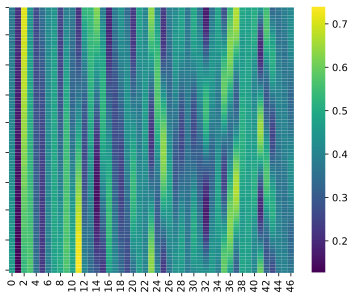

In [10]:
import seaborn as sns
num_ticks = 10
data = np.transpose(population_arr)
depth_list = np.linspace(-1/2, 1/2, 97)

# the index of the position of yticks
yticks = np.linspace(0, len(depth_list) - 1, num_ticks, dtype=np.int)
# the content of labels of these yticks
yticklabels = [depth_list[idx] for idx in yticks]

ax = sns.heatmap(data[:, 1:], yticklabels=yticklabels, cmap = 'viridis')
ax.set_yticks(yticks)
plt.show()

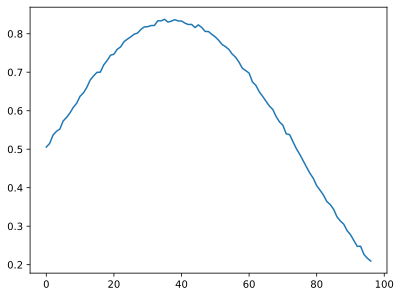

In [39]:
plt.plot(data[:, 4])

In [16]:
def ramsey_like_sim(N, xi, alpha, beta, gamma):
    psi = np.array([[1], [0], [0]])
    psi = S01(np.pi, 0, alpha) @ psi
    psi = S12(np.pi/2, -np.pi/2, beta, gamma) @ psi
    for _ in range(2*N):
        psi = S01(2*np.pi, 0, alpha) @ (psi)
    psi = S12(-np.pi/2, xi - np.pi/2, beta, gamma) @ psi
    return np.abs(*psi[1])**2


-0.0008113472982443195 -0.7874241656173395 0.7878857156821162


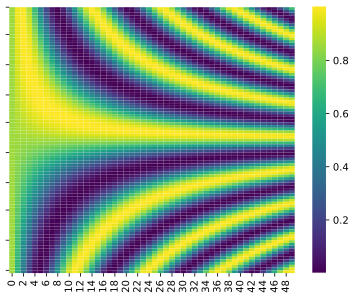

In [17]:
import seaborn as sns

alpha = np.random.uniform(-0.001, 0.001)
beta = np.pi*(-1/4 + np.random.uniform(-0.001, 0.001))
gamma = np.pi*(1/4 + np.random.uniform(-0.001, 0.001))
print(alpha, beta, gamma)
num_points_sim = 50
xi_arr_sim = np.linspace(-np.pi/50, np.pi/50, 97)

population_arr_sim = [[ramsey_like_sim(N, xi*8*N, alpha, beta, gamma) for xi in xi_arr_sim] for N in range(num_points_sim)]
num_ticks = 10
data_sim = np.transpose(population_arr_sim)
depth_list = np.linspace(-1/2, 1/2, 97)

# the index of the position of yticks
yticks = np.linspace(0, len(depth_list) - 1, num_ticks, dtype=np.int)
# the content of labels of these yticks
yticklabels = [depth_list[idx] for idx in yticks]

ax = sns.heatmap(data_sim, yticklabels=yticklabels, cmap = 'viridis')
ax.set_yticks(yticks)
plt.show()